# **Preprocessing Data (Normalisasi, dll), Analisis N-Gram, Wordcloud**

Rangkuman notebook :
1. **Eksplorasi Data** - Identifikasi kekotoran teks sebelum preprocessing
2. **Preprocessing** - Pembersihan dan normalisasi teks
3. **N-gram Analysis** - Analisis 1-gram, 2-gram, dan 3-gram

## **1. Import Libraries dan Setup**


In [ ]:
!pip install Sastrawi

In [ ]:
# Import libraries dasar
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Download NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt_tab', quiet=True)
except:
    pass

import re

print("Semua library berhasil diimport")


Semua library berhasil diimport


## **2. Load dan Eksplorasi Data** (SEBELUM Preprocessing)

Pada tahap ini, kita akan memuat data dan mengidentifikasi berbagai "kekotoran" yang ada dalam teks, seperti:
- Tag HTML (`<p>`, `<br>`, dll)
- Karakter escape (`\u003c`, `\u003e`)
- Tanda kutip dan karakter khusus
- Campuran huruf besar dan kecil
- Kata-kata yang tidak perlu (stopwords)


In [ ]:
# Load data
df = pd.read_csv('Hasil_Scraping_X.csv')

# Informasi dataset
print("=" * 60)
print("INFORMASI DATASET")
print("=" * 60)
print(f"Jumlah data: {len(df)}")
print(f"Kolom: {df.columns.tolist()}")
print("\n" + "=" * 60)

# Tampilkan beberapa contoh data mentah
print("\nCONTOH DATA MENTAH (Belum di-preprocessing):")
print("=" * 60)
for i in range(min(3, len(df))):
    print(f"\n[Contoh {i+1}]")
    print(f"Teks: {df.iloc[i]['casefolding'][:200]}...")
    print("-" * 60)

INFORMASI DATASET
Jumlah data: 1261
Kolom: ['conversation_id_str', 'created_at', 'favorite_count', 'full_text', 'id_str', 'image_url', 'in_reply_to_screen_name', 'lang', 'location', 'quote_count', 'reply_count', 'retweet_count', 'tweet_url', 'user_id_str', 'username', 'casefolding']


CONTOH DATA MENTAH (Belum di-preprocessing):

[Contoh 1]
Teks: sekarang dapur mbg makin terjamin kebersihan dan keamanannya! ‍ dengan sertifikat laik higiene setiap piring yg disajikan bukan cuma bergizi tapi juga higienis dan aman utk anak-anak kita ️ #lanjutkan...
------------------------------------------------------------

[Contoh 2]
Teks: dukung penuh mbg untuk #penuhigiziindonesia...
------------------------------------------------------------

[Contoh 3]
Teks: baru saja liat anak anak menengah kebawah sangat senang dapat mbg karna ya memang faktanya di indonesia masih banyak yang makan saja susah. tapi seharusnya pemerintah lebih memperhatikan kandungan giz...
--------------------------------------

### **2.1 Identifikasi Kekotoran Teks**

Mari kita identifikasi berbagai jenis "kekotoran" yang ada dalam dataset:


In [ ]:
# Analisis kekotoran teks
print("=" * 60)
print("IDENTIFIKASI KEKOTORAN TEKS")
print("=" * 60)

# Gabungkan semua teks
all_text = ' '.join(df['casefolding'].dropna().astype(str))

# 1. Cek tag HTML
html_tags = re.findall(r'<[^>]+>', all_text)
unique_html_tags = set(html_tags)
print(f"\n1. TAG HTML ditemukan: {len(html_tags)} instances")
print(f"   Jenis tag unik: {unique_html_tags}")

# 2. Cek karakter escape
escape_chars = re.findall(r'\\u[0-9a-fA-F]{4}', all_text)
print(f"\n2. KARAKTER ESCAPE ditemukan: {len(escape_chars)} instances")
print(f"   Contoh: {list(set(escape_chars))[:5]}")

# 3. Cek karakter khusus
special_chars = re.findall(r'[^\w\s]', all_text)
unique_special = set(special_chars)
print(f"\n3. KARAKTER KHUSUS ditemukan: {len(special_chars)} instances")
print(f"   Jenis: {sorted(unique_special)[:20]}")

# 4. Cek huruf besar
uppercase_ratio = sum(1 for c in all_text if c.isupper()) / len(all_text)
print(f"\n4. HURUF BESAR: {uppercase_ratio*100:.2f}% dari total karakter")

# 5. Cek angka
digits = re.findall(r'\d+', all_text)
print(f"\n5. ANGKA ditemukan: {len(digits)} instances")

print("\n" + "=" * 60)
print("KESIMPULAN: Data memiliki banyak noise yang perlu dibersihkan")
print("=" * 60)

IDENTIFIKASI KEKOTORAN TEKS

1. TAG HTML ditemukan: 0 instances
   Jenis tag unik: set()

2. KARAKTER ESCAPE ditemukan: 0 instances
   Contoh: []

3. KARAKTER KHUSUS ditemukan: 7134 instances
   Jenis: ['!', '#', '$', '%', '&', "'", '(', ')', '*', '+', '-', '.', '/', ':', ';', '=', '?', '@', '[', ']']

4. HURUF BESAR: 0.00% dari total karakter

5. ANGKA ditemukan: 1476 instances

KESIMPULAN: Data memiliki banyak noise yang perlu dibersihkan


### **2.2 Visualisasi WordCloud (SEBELUM Preprocessing)**

WordCloud di bawah ini menampilkan data MENTAH yang belum dibersihkan. Perhatikan bahwa masih banyak "noise" dalam teks.


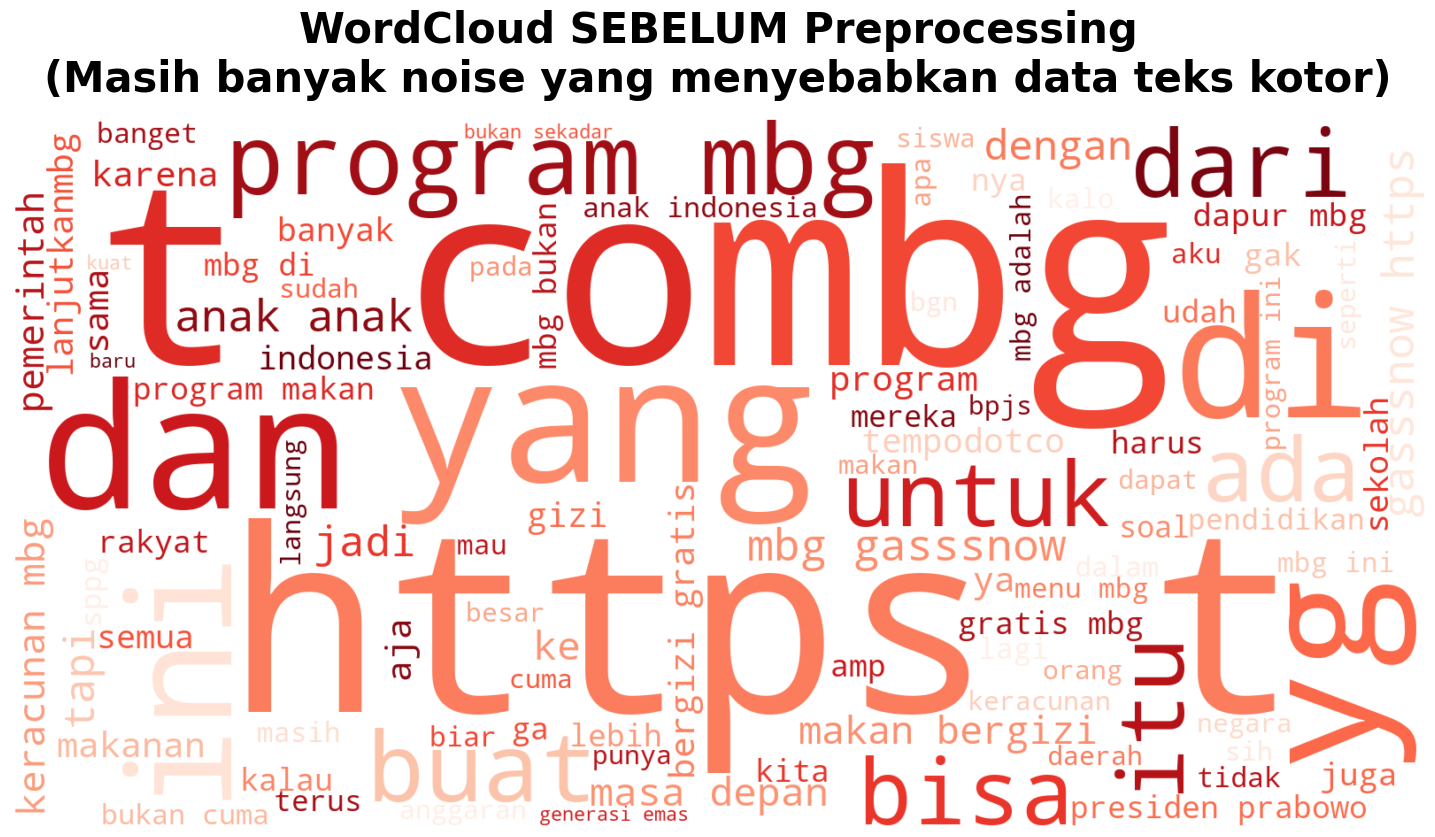


WordCloud masih mengandung banyak noise (kotor):
   - Stopwords Bahasa Indonesia (yang, di, untuk, saya, dll)
   - Karakter khusus dan angka
   - Variasi huruf besar-kecil

Selanjutnya kita akan membersihkan semua noisenya


In [ ]:
# Visualisasi WordCloud SEBELUM preprocessing
plt.figure(figsize=(15, 8))

# Gabungkan semua teks
raw_text = ' '.join(df['casefolding'].dropna().astype(str))

# Buat wordcloud
wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    colormap='Reds',
    max_words=100,
    relative_scaling=0.5,
    min_font_size=10
).generate(raw_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud SEBELUM Preprocessing\n(Masih banyak noise yang menyebabkan data teks kotor)',
          fontsize=30, fontweight='bold', pad=20)
plt.tight_layout(pad=0)
plt.show()

print("\nWordCloud masih mengandung banyak noise (kotor):")
print("   - Stopwords Bahasa Indonesia (yang, di, untuk, saya, dll)")
print("   - Karakter khusus dan angka")
print("   - Variasi huruf besar-kecil")
print("\nSelanjutnya kita akan membersihkan semua noisenya")

## **3. Text Preprocessing (Pembersihan Teks)**

Berdasarkan identifikasi kekotoran atau noise teks di atas, kita akan melakukan tahapan preprocessing berikut.

### Tahapan Preprocessing:
1. **Cleaning**: karakter escape, URL, karakter khusus, dll
2. **Case Folding**: Mengubah semua huruf menjadi lowercase
3. **Tokenization**: Memecah teks menjadi kata-kata (tokens)
4. **Stopword Removal**: Menghapus kata-kata yang tidak penting (gabungan NLTK + Sastrawi)
5. **Normalization**: Menormalisasi kata-kata yang tidak baku (slang, typo, dll)
6. **Stemming**: Mengubah kata ke bentuk dasarnya menggunakan Sastrawi

Mari kita implementasikan setiap tahap.


In [ ]:
# Setup untuk preprocessing
print("Setup preprocessing tools...")



# 1. Gabungkan stopwords dari NLTK dan Sastrawi
try:
    nltk_stopwords = set(stopwords.words('indonesian'))
except:
    nltk_stopwords = set()

sastrawi_factory = StopWordRemoverFactory()
sastrawi_stopwords = set(sastrawi_factory.get_stop_words())

# Gabungkan kedua kamus stopwords
combined_stopwords = nltk_stopwords.union(sastrawi_stopwords)

# Tambahkan beberapa stopwords custom yang sering muncul di data medis
custom_stopwords = {'halo', 'hai', 'terima', 'kasih',
                    'permisi', 'selamat', 'pagi', 'siang', 'sore', 'malam',
                    'mohon', 'ijin', 'maaf', 'assalamualaikum', 'wrwb', 'nya', 'sih'}
combined_stopwords = combined_stopwords.union(custom_stopwords)

print(f"Total stopwords: {len(combined_stopwords)} kata")

# 2. Setup Stemmer dari Sastrawi
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

print("Stemmer Sastrawi siap")

# 3. Load kamus normalisasi dari GitHub
print("\nMemuat kamus normalisasi dari GitHub...")
# URL raw file dari GitHub
url = "https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv"

# Baca CSV dari URL
normalization_df = pd.read_csv(url)

# Buat dictionary dari kolom 'slang' dan 'formal'
normalization_dict = dict(zip(normalization_df['slang'], normalization_df['formal']))

# Biarkan slang tertentu tidak dinormalisasi
excluded_slangs = {'mbg','mba'}
for slang in excluded_slangs:
    if slang in normalization_dict:
        del normalization_dict[slang]  # hapus dari kamus

print(f"Kamus normalisasi dimuat: {len(normalization_dict)} kata")
# Tampilkan beberapa contoh
print(f"\nContoh kamus normalisasi (5 entri pertama):")
for i, (slang, formal) in enumerate(list(normalization_dict.items())[:5]):
    print(f"  {slang:15s} → {formal}")

print("\nSemua tools preprocessing siap!")
print("Semua tools preprocessing siap!")

Setup preprocessing tools...
Total stopwords: 791 kata
Stemmer Sastrawi siap

Memuat kamus normalisasi dari GitHub...
Kamus normalisasi dimuat: 4329 kata

Contoh kamus normalisasi (5 entri pertama):
  woww            → wow
  aminn           → amin
  met             → selamat
  netaas          → menetas
  keberpa         → keberapa

Semua tools preprocessing siap!
Semua tools preprocessing siap!


In [ ]:
def preprocess_text(text, remove_stopwords=True, do_stemming=True):
    """
    Fungsi untuk preprocessing teks dengan tahapan lengkap:
    1. Cleaning (HTML, escape chars, special chars)
    2. Case folding
    3. Tokenization
    4. Normalization
    5. Stopword removal (optional)
    6. Stemming (optional)

    Args:
        text: String teks yang akan diproses
        remove_stopwords: Boolean untuk menghapus stopwords
        do_stemming: Boolean untuk melakukan stemming

    Returns:
        String teks yang sudah diproses
    """
    if pd.isna(text) or text == '':
        return ''

    # 1. CLEANING
    # Hapus karakter escape unicode
    text = text.encode('utf-8').decode('unicode-escape', errors='ignore')

    # Hapus HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)

    # Hapus URL
    text = re.sub(r'http\S+|www\S+', '', text)

    # Hapus email
    text = re.sub(r'\S+@\S+', '', text)

    # Hapus angka
    text = re.sub(r'\d+', '', text)

    # 2. CASE FOLDING - ubah ke lowercase
    text = text.lower()

    # Hapus karakter khusus dan tanda baca, hanya simpan huruf dan spasi
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Hapus extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Ubah karakter yang berulang >2x menjadi satu karakter saja (contoh: baaaaguuusss → bagus)
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # 3. TOKENIZATION
    tokens = text.split()

    # 4. NORMALIZATION - gunakan kamus normalisasi
    tokens = [normalization_dict.get(word, word) for word in tokens]

    # 5. STOPWORD REMOVAL
    if remove_stopwords:
        tokens = [word for word in tokens if word not in combined_stopwords and len(word) > 2]

    # 6. STEMMING
    if do_stemming:
        tokens = [stemmer.stem(word) for word in tokens]

    # Gabungkan kembali menjadi string
    result = ' '.join(tokens)

    return result

print("Fungsi preprocessing telah dibuat")


Fungsi preprocessing telah dibuat


### **3.2 Aplikasi Preprocessing pada Dataset**


In [ ]:
# Terapkan preprocessing pada dataset
print("Melakukan preprocessing pada semua data...")
# Buat kolom baru untuk teks yang sudah diproses
df['cleaned_text'] = df['casefolding'].apply(lambda x: preprocess_text(x,
                                                                       remove_stopwords=True,
                                                                       do_stemming=True))

# Hapus baris dengan teks kosong setelah preprocessing
df = df[df['cleaned_text'].str.strip() != '']

Melakukan preprocessing pada semua data...


In [ ]:
# Tampilkan perbandingan SEBELUM dan SESUDAH preprocessing
print("\n" + "=" * 80)
print("PERBANDINGAN SEBELUM DAN SESUDAH PREPROCESSING")
print("=" * 80)

for i in range(min(3, len(df))):
    print(f"\n[CONTOH {i+1}]")
    print(f"\nSEBELUM:")
    print(f"{df.iloc[i]['casefolding'][:300]}...")
    print(f"\nSESUDAH:")
    print(f"{df.iloc[i]['cleaned_text']}")
    print("-" * 80)


PERBANDINGAN SEBELUM DAN SESUDAH PREPROCESSING

[CONTOH 1]

SEBELUM:
sekarang dapur mbg makin terjamin kebersihan dan keamanannya! ‍ dengan sertifikat laik higiene setiap piring yg disajikan bukan cuma bergizi tapi juga higienis dan aman utk anak-anak kita ️ #lanjutkanmbg _ pagiii pagii jumathello pledis fokus mewujudkan visi amanda manopo https://t.co/vj2hst3vya...

SESUDAH:
dapur mbg jamin bersih aman sertifikat laik higiene piring saji gizi higienis aman anak anak lanjutkanmbg pagi jumathello pledis fokus wujud visi amanda manopo
--------------------------------------------------------------------------------

[CONTOH 2]

SEBELUM:
dukung penuh mbg untuk #penuhigiziindonesia...

SESUDAH:
dukung penuh mbg penuhigiziindonesia
--------------------------------------------------------------------------------

[CONTOH 3]

SEBELUM:
baru saja liat anak anak menengah kebawah sangat senang dapat mbg karna ya memang faktanya di indonesia masih banyak yang makan saja susah. tapi seharusnya peme

## **4. Visualisasi SETELAH Preprocessing Normalisasi dan N-gram Analysis**

Sekarang mari kita lihat hasil pembersihan dengan visualisasi WordCloud baru, dan juga analisis N-gram.


### **4.1 WordCloud SETELAH Preprocessing**


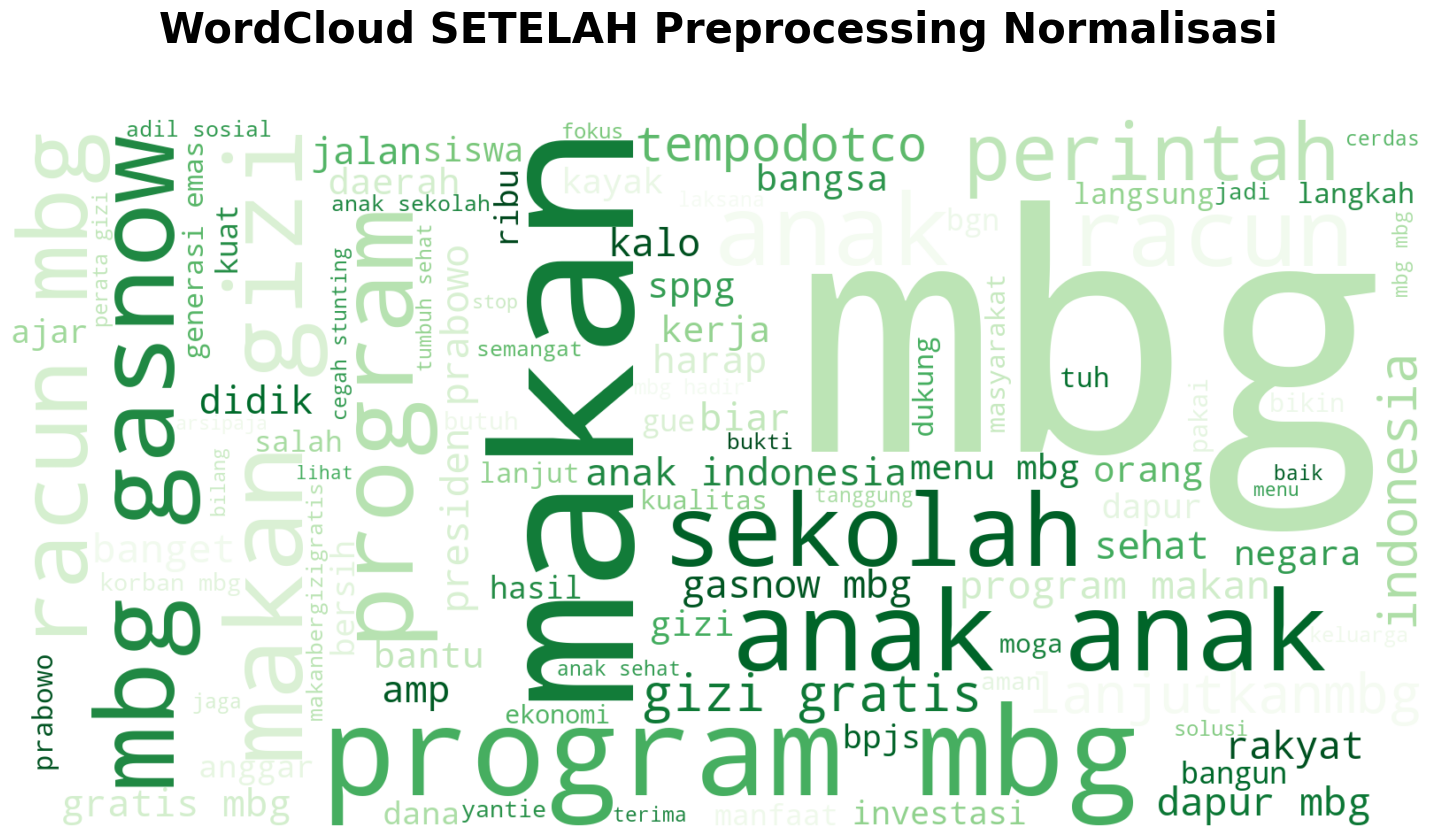


WordCloud jauh lebih bersih
   - Stopwords sudah dihapus
   - Kata-kata sudah di-stem ke bentuk dasar
   - Hanya kata-kata penting yang muncul (kanker, payudara, operasi, stadium, dll)

Data siap untuk pemodelan!


In [ ]:
# Visualisasi WordCloud SETELAH preprocessing
plt.figure(figsize=(15, 8))

# Gabungkan semua teks yang sudah dibersihkan
cleaned_text = ' '.join(df['cleaned_text'].values)

# Buat wordcloud
wordcloud_clean = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    colormap='Greens',
    max_words=100,
    relative_scaling=0.5,
    min_font_size=10
).generate(cleaned_text)

plt.imshow(wordcloud_clean, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud SETELAH Preprocessing Normalisasi\n',
          fontsize=30, fontweight='bold', pad=20)
plt.tight_layout(pad=0)
plt.show()

print("\nWordCloud jauh lebih bersih")
print("   - Stopwords sudah dihapus")
print("   - Kata-kata sudah di-stem ke bentuk dasar")
print("   - Hanya kata-kata penting yang muncul (kanker, payudara, operasi, stadium, dll)")
print("\nData siap untuk pemodelan!")


### **4.2 Analisis N-gram**

**N-gram** adalah sekuens dari N kata yang berdekatan dalam teks. Analisis N-gram membantu kita memahami:
- **2-gram (Bigram)**: Pasangan kata yang sering muncul bersama
- **3-gram (Trigram)**: Tiga kata yang sering muncul bersama

Ini berguna untuk memahami konteks dan pola dalam teks.


In [ ]:
from collections import Counter

def get_ngrams(text_list, n=2, top_k=20):
    """
    Ekstrak n-grams dari list teks

    Args:
        text_list: List of strings
        n: Ukuran n-gram (2 untuk bigram, 3 untuk trigram)
        top_k: Jumlah n-gram teratas yang akan dikembalikan

    Returns:
        List of tuples (ngram, frequency)
    """
    ngrams_list = []

    for text in text_list:
        words = text.split()
        # Buat n-grams
        ngrams = [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
        ngrams_list.extend(ngrams)

    # Hitung frekuensi
    ngram_freq = Counter(ngrams_list)

    # Ambil top_k
    return ngram_freq.most_common(top_k)

# Ekstrak 1-grams, 2-grams, dan 3-grams
onegrams = get_ngrams(df['cleaned_text'].values, n=1, top_k=20)
bigrams = get_ngrams(df['cleaned_text'].values, n=2, top_k=20)
trigrams = get_ngrams(df['cleaned_text'].values, n=3, top_k=20)

print("=" * 80)
print("TOP 20 ONEGRAMS (1-gram)")
print("=" * 80)
for i, (ngram, freq) in enumerate(onegrams, 1):
    print(f"{i:2d}. {' '.join(ngram):40s} : {freq:3d} kali")

print("=" * 80)
print("TOP 20 BIGRAMS (2-gram)")
print("=" * 80)
for i, (ngram, freq) in enumerate(bigrams, 1):
    print(f"{i:2d}. {' '.join(ngram):40s} : {freq:3d} kali")

print("\n" + "=" * 80)
print("TOP 20 TRIGRAMS (3-gram)")
print("=" * 80)
for i, (ngram, freq) in enumerate(trigrams, 1):
    print(f"{i:2d}. {' '.join(ngram):50s} : {freq:3d} kali")


TOP 20 ONEGRAMS (1-gram)
 1. mbg                                      : 1494 kali
 2. anak                                     : 422 kali
 3. makan                                    : 318 kali
 4. program                                  : 312 kali
 5. gizi                                     : 295 kali
 6. racun                                    : 187 kali
 7. sehat                                    : 141 kali
 8. indonesia                                : 139 kali
 9. sekolah                                  : 122 kali
10. gratis                                   : 111 kali
11. gasnow                                   : 111 kali
12. prabowo                                  :  99 kali
13. dapur                                    :  95 kali
14. lanjutkanmbg                             :  83 kali
15. perintah                                 :  79 kali
16. generasi                                 :  78 kali
17. menu                                     :  68 kali
18. kerja             

**Visualisasi N-Grams**

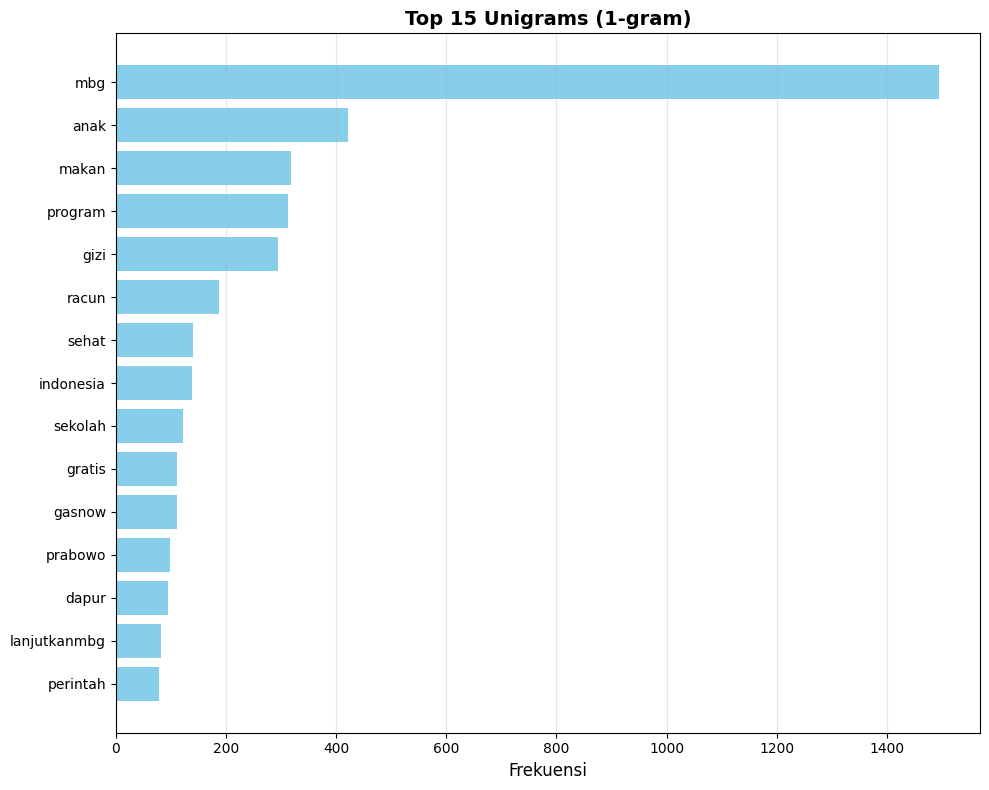

✓ Unigram plot selesai



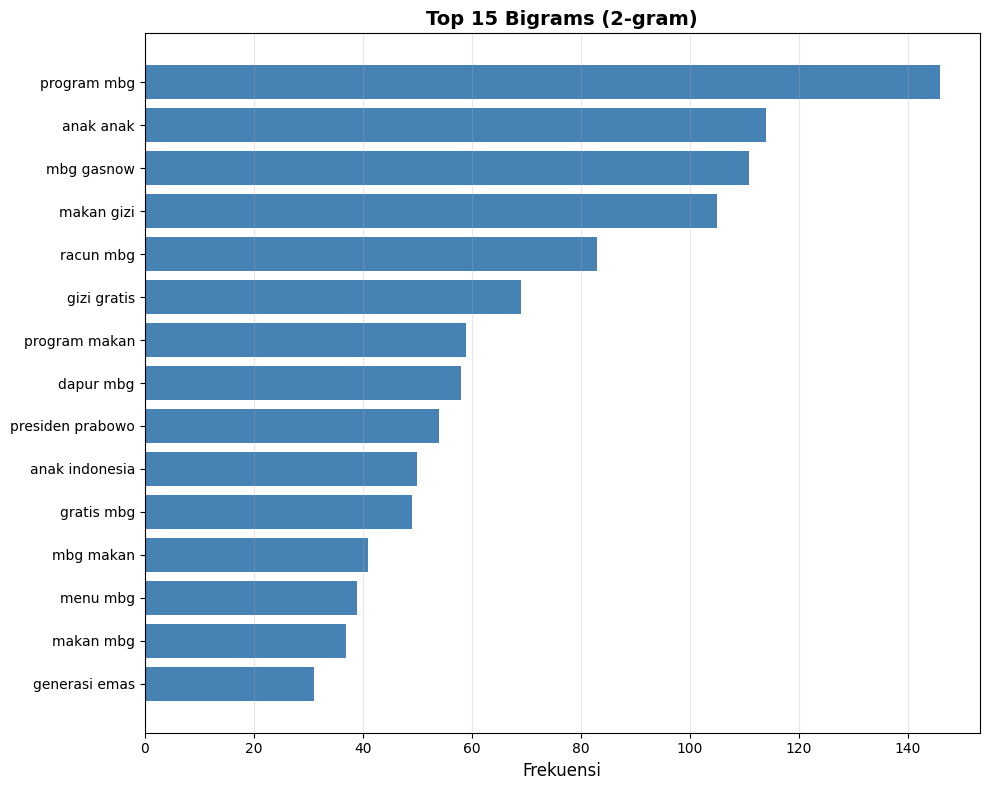

✓ Bigram plot selesai



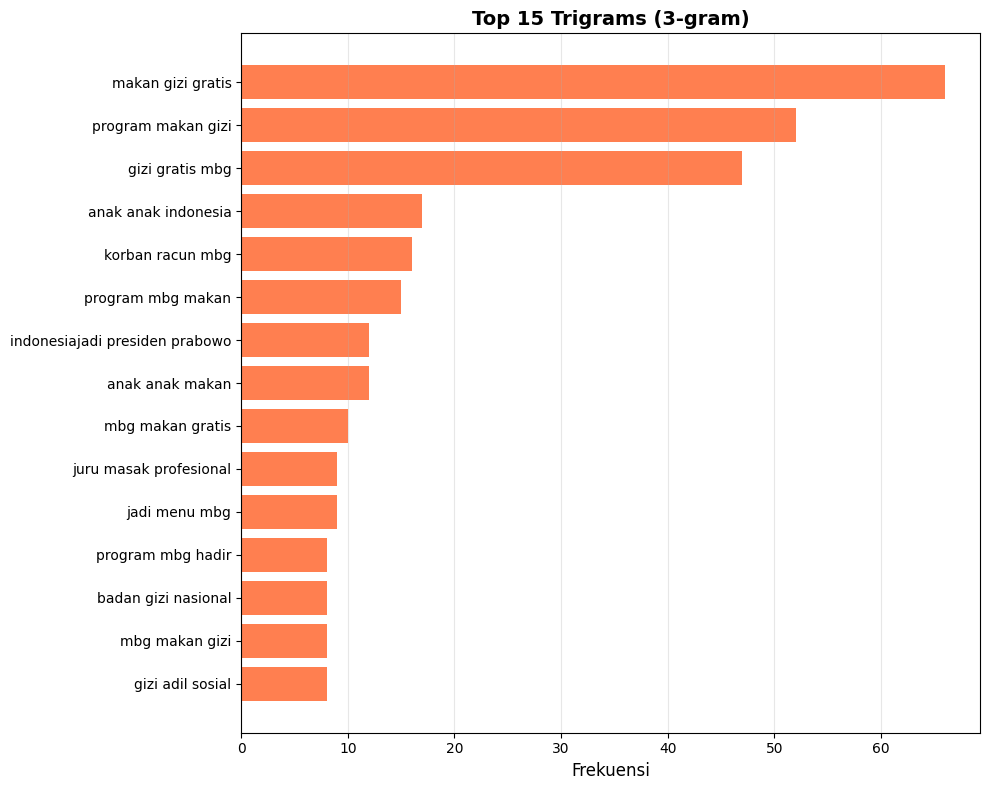

✓ Trigram plot selesai

ANALISIS N-GRAM SELESAI!

INSIGHT dari N-gram:
- Unigram menunjukkan kata tunggal yang paling sering muncul
- Bigram dan trigram menunjukkan frasa yang sering digunakan dalam MBG di Twitter
- Membantu memahami konteks percakapan dalam dataset


In [ ]:
# ============================================================================
# PLOT 1: UNIGRAMS (1-gram)
# ============================================================================
plt.figure(figsize=(10, 8))

onegram_words = [' '.join(og[0]) for og in onegrams]
onegram_counts = [og[1] for og in onegrams]

plt.barh(onegram_words[:15], onegram_counts[:15], color='skyblue')
plt.xlabel('Frekuensi', fontsize=12)
plt.title('Top 15 Unigrams (1-gram)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Unigram plot selesai\n")

# ============================================================================
# PLOT 2: BIGRAMS (2-gram)
# ============================================================================
plt.figure(figsize=(10, 8))

bigram_words = [' '.join(bg[0]) for bg in bigrams]
bigram_counts = [bg[1] for bg in bigrams]

plt.barh(bigram_words[:15], bigram_counts[:15], color='steelblue')
plt.xlabel('Frekuensi', fontsize=12)
plt.title('Top 15 Bigrams (2-gram)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Bigram plot selesai\n")

# ============================================================================
# PLOT 3: TRIGRAMS (3-gram)
# ============================================================================
plt.figure(figsize=(10, 8))

trigram_words = [' '.join(tg[0]) for tg in trigrams]
trigram_counts = [tg[1] for tg in trigrams]

plt.barh(trigram_words[:15], trigram_counts[:15], color='coral')
plt.xlabel('Frekuensi', fontsize=12)
plt.title('Top 15 Trigrams (3-gram)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Trigram plot selesai\n")

# ============================================================================
# INSIGHT
# ============================================================================
print("=" * 80)
print("ANALISIS N-GRAM SELESAI!")
print("=" * 80)
print("\nINSIGHT dari N-gram:")
print("- Unigram menunjukkan kata tunggal yang paling sering muncul")
print("- Bigram dan trigram menunjukkan frasa yang sering digunakan dalam MBG di Twitter")
print("- Membantu memahami konteks percakapan dalam dataset")
print("=" * 80)

### **4.3 WordCloud untuk Unigram, Bigram, dan Trigram**

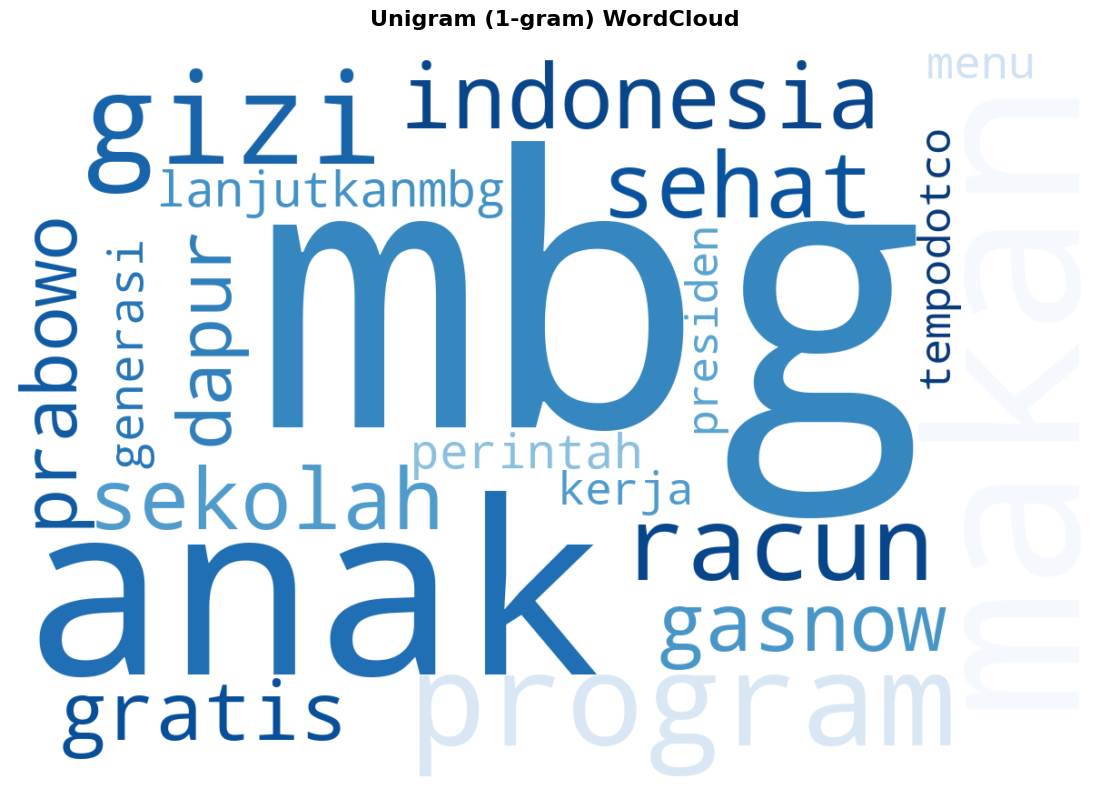

✓ Unigram WordCloud selesai



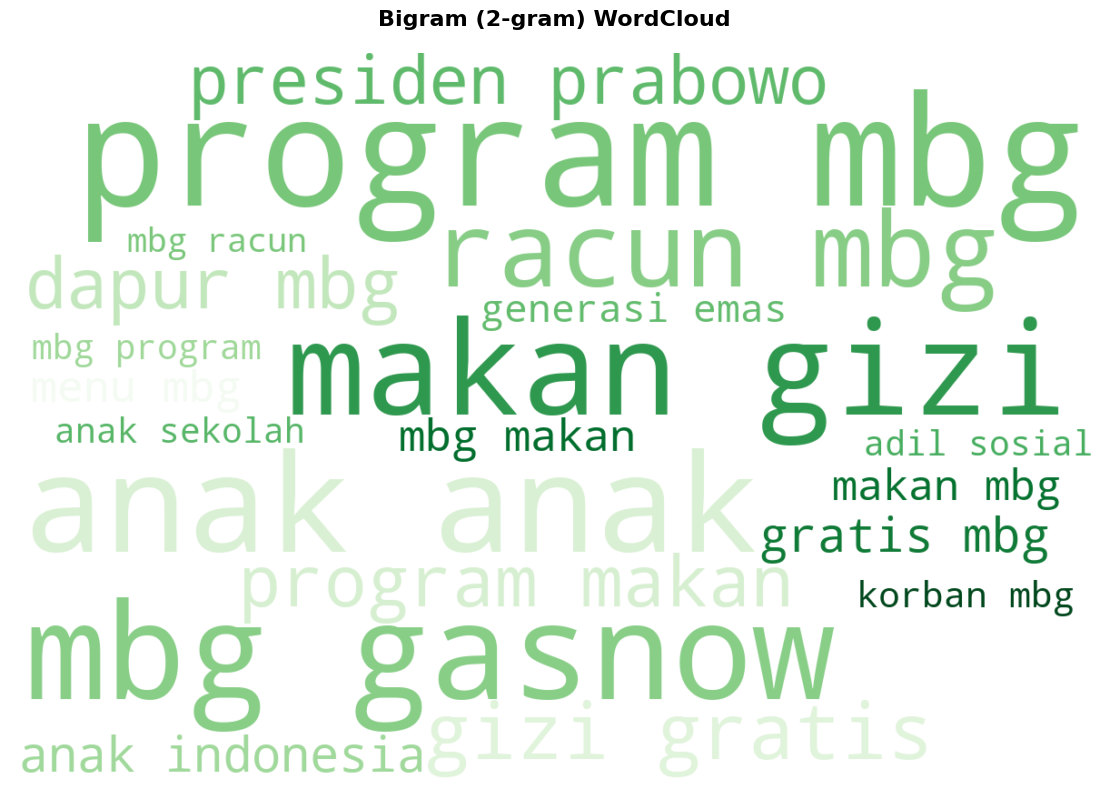

✓ Bigram WordCloud selesai



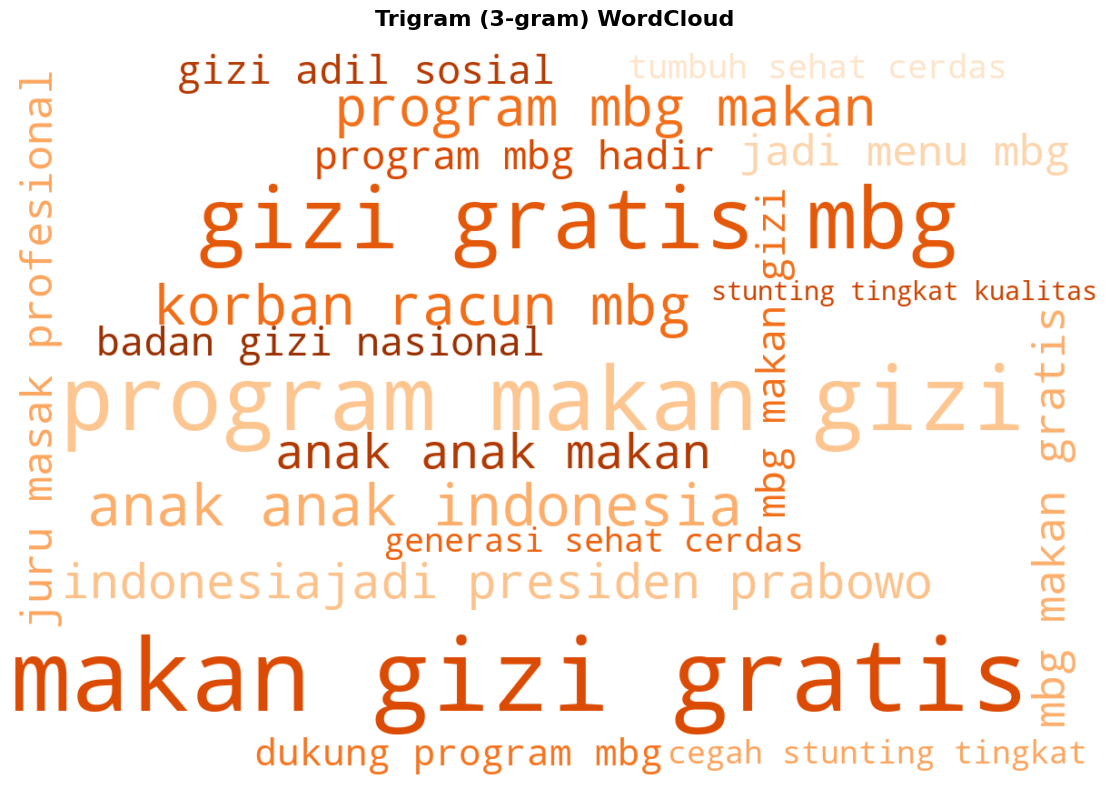

✓ Trigram WordCloud selesai


WORDCLOUD N-GRAM ANALYSIS
✓ Unigram WordCloud: Menampilkan kata tunggal yang paling sering muncul
✓ Bigram WordCloud: Menampilkan pasangan kata yang paling sering muncul bersama
✓ Trigram WordCloud: Menampilkan tiga kata yang paling sering muncul bersama

INSIGHT:
- Semakin besar ukuran kata, semakin sering kata/frasa tersebut muncul
- Bigram dan trigram membantu memahami konteks dan frasa yang umum digunakan


In [ ]:
# ============================================================================
# WORDCLOUD 1: UNIGRAM (1-gram)
# ============================================================================
plt.figure(figsize=(12, 8))

# Konversi onegrams ke dictionary untuk wordcloud
unigram_dict = {' '.join(ngram): freq for ngram, freq in onegrams}

wordcloud_unigram = WordCloud(
    width=1200,
    height=800,
    background_color='white',
    colormap='Blues',
    relative_scaling=0.5,
    min_font_size=10
).generate_from_frequencies(unigram_dict)

plt.imshow(wordcloud_unigram, interpolation='bilinear')
plt.axis('off')
plt.title('Unigram (1-gram) WordCloud', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("✓ Unigram WordCloud selesai\n")

# ============================================================================
# WORDCLOUD 2: BIGRAM (2-gram)
# ============================================================================
plt.figure(figsize=(12, 8))

# Konversi bigrams ke dictionary untuk wordcloud
bigram_dict = {' '.join(ngram): freq for ngram, freq in bigrams}

wordcloud_bigram = WordCloud(
    width=1200,
    height=800,
    background_color='white',
    colormap='Greens',
    relative_scaling=0.5,
    min_font_size=10
).generate_from_frequencies(bigram_dict)

plt.imshow(wordcloud_bigram, interpolation='bilinear')
plt.axis('off')
plt.title('Bigram (2-gram) WordCloud', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("✓ Bigram WordCloud selesai\n")

# ============================================================================
# WORDCLOUD 3: TRIGRAM (3-gram)
# ============================================================================
plt.figure(figsize=(12, 8))

# Konversi trigrams ke dictionary untuk wordcloud
trigram_dict = {' '.join(ngram): freq for ngram, freq in trigrams}

wordcloud_trigram = WordCloud(
    width=1200,
    height=800,
    background_color='white',
    colormap='Oranges',
    relative_scaling=0.5,
    min_font_size=10
).generate_from_frequencies(trigram_dict)

plt.imshow(wordcloud_trigram, interpolation='bilinear')
plt.axis('off')
plt.title('Trigram (3-gram) WordCloud', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("✓ Trigram WordCloud selesai\n")

# ============================================================================
# INSIGHT
# ============================================================================
print("\n" + "=" * 80)
print("WORDCLOUD N-GRAM ANALYSIS")
print("=" * 80)
print("✓ Unigram WordCloud: Menampilkan kata tunggal yang paling sering muncul")
print("✓ Bigram WordCloud: Menampilkan pasangan kata yang paling sering muncul bersama")
print("✓ Trigram WordCloud: Menampilkan tiga kata yang paling sering muncul bersama")
print("\nINSIGHT:")
print("- Semakin besar ukuran kata, semakin sering kata/frasa tersebut muncul")
print("- Bigram dan trigram membantu memahami konteks dan frasa yang umum digunakan")
print("=" * 80)